In [1]:
import pandas as pd
import numpy as np

In [2]:
output_names = ['beckerestimation', 'csopII', 'DAT', 'gurcay2015estimation', 'jury', 'jury_TINY', 'pgg']

In [4]:
directory="./output/"
for dataset in output_names:
    csv_path = directory + dataset + '_output_conversation_level.csv'
    df = pd.read_csv(csv_path)
    print(dataset + ": " + str(df['discursive_diversity'].mean()))



beckerestimation: 0.5549970479799256
csopII: 0.3544905237781474
DAT: 0.40334599936569776
gurcay2015estimation: 0.5945824004726163
jury: 0.426955241253606
jury_TINY: 0.3846901386808177
pgg: 0.21534238301404293


## Intuitive unit tests for DD

In [9]:
from features.discursive_diversity import *
from utils.preprocess import *

In [7]:
vect_data = pd.read_csv("./embeddings/juries_tiny_for_testing.csv")

In [11]:
chat_data = preprocess_conversation_columns(pd.read_csv("./data/raw_data/juries_tiny_for_testing.csv"))

# have to add embedding column before passing into get_DD


In [12]:
get_DD(chat_data)

KeyError: 'Column not found: message_embedding'

# DD Over Time
The original DD paper makes a big deal about how DD changes over time. Can we see meaningful patterns?

In [11]:
## What about DD over time?
import matplotlib.pyplot as plt
import math

In [1]:
# this is in utils - copying here for ease of access lol
def preprocess_conversation_columns(df):
	# remove all special characters from df
	df.columns = df.columns.str.replace('[^A-Za-z0-9_]', '', regex=True)
	
	# If data is grouped by batch/round, add a conversation num
	if {'batch_num', 'round_num'}.issubset(df.columns):
		df['conversation_num'] = df.groupby(['batch_num', 'round_num']).ngroup()
		df = df[df.columns.tolist()[-1:] + df.columns.tolist()[0:-1]] # make the new column first

	return(df)

In [2]:
def get_and_preprocess_chats(chat_path, vec_path):
    chat_data = pd.read_csv(chat_path)
    vec_data = pd.read_csv(vec_path)
    chat_data = preprocess_conversation_columns(chat_data)
    chat_data = pd.merge(chat_data, vec_data["message_embedding"], left_index=True, right_index=True)
    
    return chat_data, vec_data

In [60]:
#CHECK UTILS FOLDER FOR COMPLETED ASSIGN_CHUNK_NUM FUNCTIONALITY

# Assign chunk numbers to the chats within each conversation
def assign_chunk_nums(chat_data):

    # Calculate the total number of rows per conversation
    conversation_lengths = chat_data.groupby('conversation_num').size()
    num_conversations = chat_data['conversation_num'].nunique()

    # Calculate the chunk size based on the total number of conversations
    chunk_size = np.ceil(conversation_lengths / 11) # I found that using 10 in the bottom actually only generates 9 groups, so here I use 11 ... (weird)

    for i, group in chat_data.groupby('conversation_num'): # for each group
        chunk_num = 0
        counter = 0

        for chat_id in group.index.values: # iterate over the index values
            chat_data.at[chat_id, 'chunk_num'] = chunk_num

            counter += 1

            if counter == chunk_size[i] and chunk_num < 9: # assign any extras to the last chunk
                chunk_num += 1
                counter = 0

    return(chat_data)

In [3]:
def get_dd_results_by_chunk(chat_data, vector_data):
    dd_results = chat_data.groupby(['conversation_num', 'chunk_num']).apply(lambda x: get_DDD(x))
    dd_results = dd_results.reset_index(drop=True)
    dd_results['chunk_num'] = dd_results.groupby('conversation_num').cumcount() + 1

    return(dd_results)

In [55]:
# Plot the results
def plot_dd_results(dd_results):

    plt.figure(figsize=(12, 6))
    for conversation_num, group in dd_results.groupby('conversation_num'):
        plt.plot(group['chunk_num'], group['discursive_diversity'], label=f'Conversation {conversation_num}')

    plt.xlabel('Chunk Number (Each contains 10% of chats)')
    plt.ylabel('Discursive Diversity')
    plt.title('Discursive Diversity Over Time')
    plt.show()

## Juries

In [65]:
chat_juries, vect_juries = get_and_preprocess_chats("../data/raw_data/jury_conversations_with_outcome_var.csv", "../embeddings/jury_conversations_with_outcome_var.csv")

In [78]:
from get_all_DD_features import *
from discursive_diversity import *
from variance_in_DD import *
from within_person_discursive_range import *


In [80]:
chat_juries = assign_chunk_nums(chat_juries, 10)
chat_juries

,conversation_num,batch_num,round_num,speaker_hash,speaker_nickname,timestamp,message,majority_pct,num_flipped,flipped_pct,num_votes,message_embedding,chunk_num
0,0,0,0,5e7e1e0031f4e454e196c30b,niceRhino,2020-04-20T18:27:20.125Z,Hello!,1.000000,1,0.333333,3,"[-0.06062670424580574, 0.039964862167835236, 0...",0
1,0,0,0,5e31d6e4e31c5304c46f1413,culturedCow,2020-04-20T18:27:23.764Z,Hi!,1.000000,1,0.333333,3,"[-0.08946916460990906, 0.03267912194132805, 0....",0
2,0,0,0,5e7e4f4c31f4e454e196c9c4,spryBison,2020-04-20T18:27:27.724Z,Hello,1.000000,1,0.333333,3,"[-0.0627717450261116, 0.054958783090114594, 0....",0
3,0,0,0,5d482ea421c9be351f762255,youngLion,2020-04-20T18:27:30.410Z,Hi,1.000000,1,0.333333,3,"[-0.09047628939151764, 0.04043957591056824, 0....",0
4,0,0,0,5e84cc3c50f6e364321d6265,smallGiraffe,2020-04-20T18:27:35.506Z,hi,1.000000,1,0.333333,3,"[-0.09047628939151764, 0.04043957591056824, 0....",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14883,347,177,3,5f1f466846a7f03dda9b37c3,eagerElephant,2020-07-28T22:36:22.226Z,I think he is the asshole,0.666667,1,0.333333,3,"[-0.031704120337963104, 0.028209084644913673, ...",9
14884,347,177,3,5f1a214246a7f03dda9a6aad,inspiredGiraffe,2020-07-28T22:36:46.155Z,He didn't vent to them or take up frustrations...,0.666667,1,0.333333,3,"[0.07338588684797287, 0.07632914185523987, -0....",9
14885,347,177,3,5f2096dab0aafc741f6865bb,inquisitiveBison,2020-07-28T22:36:49.238Z,very interested,0.666667,1,0.333333,3,"[-0.034968648105859756, -0.040833573788404465,...",9
14886,347,177,3,5f1f472646a7f03dda9b3895,excitedDolphin,2020-07-28T22:36:51.487Z,"I'm fine with venting on Reddit, I just don't ...",0.666667,1,0.333333,3,"[0.060588594526052475, 0.040215298533439636, -...",9


In [79]:
chat_juries['message_embedding'] = conv_to_float_arr(chat_juries['message_embedding'].to_frame())

In [296]:
def conv_to_float_arr(df):
    if isinstance(df['message_embedding'][0], str):
            df['message_embedding'] = [val[1:-1] for val in df['message_embedding']]
            df['message_embedding'] = [[float(e) for e in embedding.split(',')] for embedding in df['message_embedding']]
            df['message_embedding'] = [np.array(e) for e in df['message_embedding']]
    return df

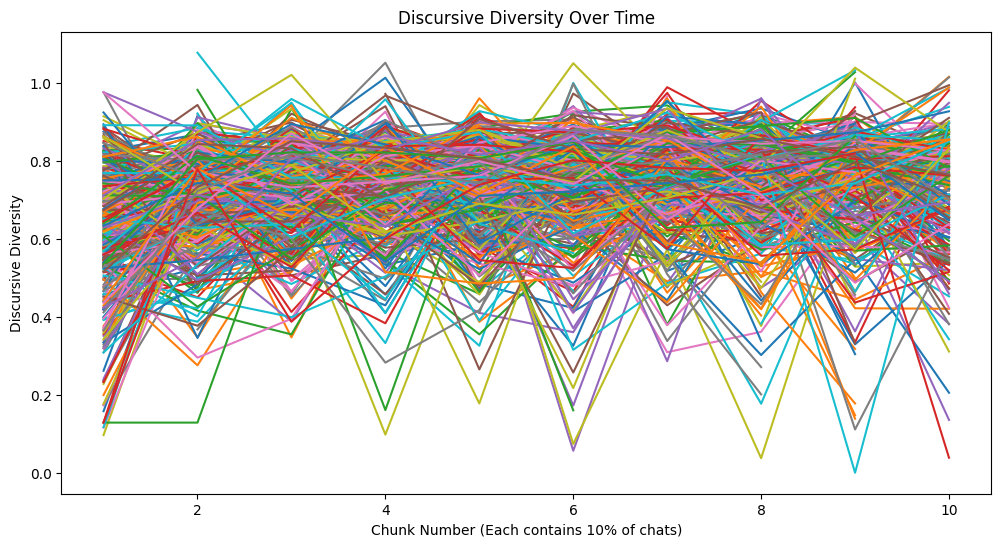

In [58]:
plot_dd_results(get_dd_results_by_chunk(chat_juries,vect_juries))

## CSOP II

In [283]:
chat_csop2, vect_csop2 = get_and_preprocess_chats("../data/raw_data/csopII_conversations_withblanks.csv", "../embeddings/csopII_conversations_withblanks.csv")

In [286]:
chat_csop2 = assign_chunk_nums(chat_csop2)

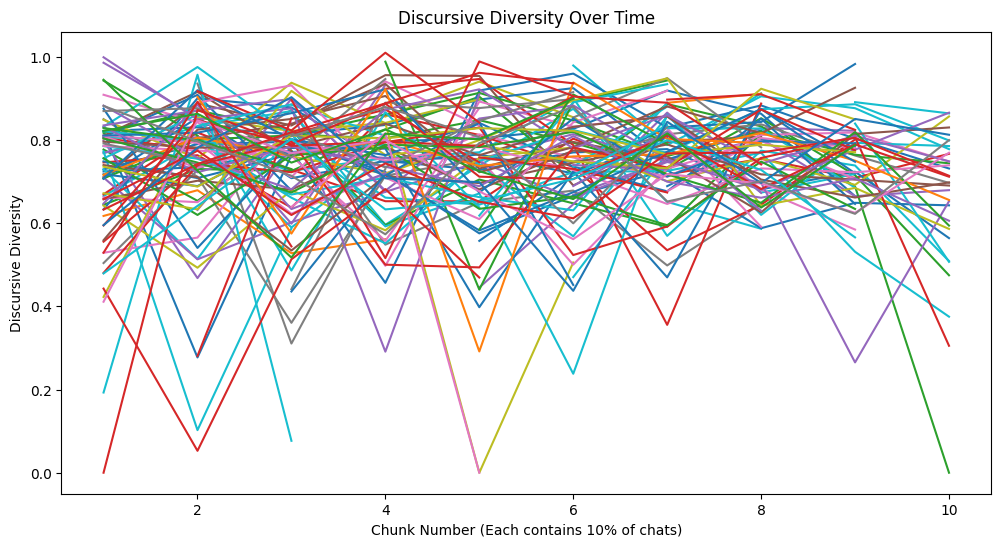

In [287]:
plot_dd_results(get_dd_results_by_chunk(chat_csop2, vect_csop2))

# Calculating Within-Person Discursive Range Temporal Metrics

In [19]:
# calculate mean vector per chunk per speaker
mean_vec_speaker_chunks = pd.DataFrame(chat_juries.groupby(['conversation_num', 'speaker_nickname', 'chunk_num']).message_embedding.apply(np.mean)).unstack('chunk_num').rename(columns={'message_embedding': 'mean_chunk_vec'})
mean_vec_speaker_chunks

mean_chunk_vec   
chunk_num                                                                          0   
conversation_num speaker_nickname                                                      
0                culturedBear                                                    NaN  \
                 culturedCow       [-0.08946916460990906, 0.03267912194132805, 0....   
                 littleSquirrel                                                  NaN   
                 niceRhino         [-0.06062670424580574, 0.039964862167835236, 0...   
                 smallGiraffe      [-0.09047628939151764, 0.04043957591056824, 0....   
...                                                                              ...   
347              eagerElephant                                                   NaN   
                 excitedDolphin    [-0.08046487718820572, 0.044428322464227676, 0...   
                 fulfilledCamel    [-0.05634737014770508, -0.007715309504419565, ...   
                 inquisitiveBison  [-0.026782882632687688, -0.014089254662394524,...   
                 inspiredGiraffe   [-0.0627717450261116, 0.054958783090114594, 0....   

                                                                                       
chunk_num                                                                          1   
conversation_num speaker_nickname                                                      
0                culturedBear      [-0.0627717450261116, 0.054958783090114594, 0....  \
                 culturedCow                                                     NaN   
                 littleSquirrel                                                  NaN   
                 niceRhino         [0.022797171026468277, 0.058086082339286804, -...   
                 smallGiraffe      [0.004202700685709715, 0.04377860948443413, 0....   
...                                                                              ...   
347              eagerElephant     [0.005290661472827196, -0.01910887286067009, 0...   
                 excitedDolphin                                                  NaN   
                 fulfilledCamel    [0.0047978066286304966, 0.010664364323019981, ...   
                 inquisitiveBison  [-0.030651554465293884, 0.0007207386079244316,...   
                 inspiredGiraffe   [-0.0025855498388409615, 0.030274693854153156,...   

                                                                                       
chunk_num                                                                          2   
conversation_num speaker_nickname                                                      
0                culturedBear                                                    NaN  \
                 culturedCow       [0.051103007048368454, 0.06420852243900299, -0...   
                 littleSquirrel                                                  NaN   
                 niceRhino         [0.027290978701785207, -0.027212316170334816, ...   
                 smallGiraffe      [0.026743454858660698, -0.06807675212621689, 0...   
...                                                                              ...   
347              eagerElephant     [-0.012836170848459005, 0.011020568199455738, ...   
                 excitedDolphin    [0.05821012705564499, 0.02074747160077095, 0.0...   
                 fulfilledCamel                                                  NaN   
                 inquisitiveBison  [-0.08006388787180185, 0.001438195256923791, -...   
                 inspiredGiraffe   [-0.01166983600705862, -0.018159817904233932, ...   

                                                                                       
chunk_num                                                                          3   
conversation_num speaker_nickname                                                      
0                culturedBear                                                    NaN  \
                 cu

In [20]:
mean_vec_speaker_chunks.columns = ["_c".join(col).strip() for col in mean_vec_speaker_chunks.columns.values]
mean_vec_speaker_chunks

mean_chunk_vec_c0   
conversation_num speaker_nickname                                                      
0                culturedBear                                                    NaN  \
                 culturedCow       [-0.08946916460990906, 0.03267912194132805, 0....   
                 littleSquirrel                                                  NaN   
                 niceRhino         [-0.06062670424580574, 0.039964862167835236, 0...   
                 smallGiraffe      [-0.09047628939151764, 0.04043957591056824, 0....   
...                                                                              ...   
347              eagerElephant                                                   NaN   
                 excitedDolphin    [-0.08046487718820572, 0.044428322464227676, 0...   
                 fulfilledCamel    [-0.05634737014770508, -0.007715309504419565, ...   
                 inquisitiveBison  [-0.026782882632687688, -0.014089254662394524,...   
                 inspiredGiraffe   [-0.0627717450261116, 0.054958783090114594, 0....   

                                                                   mean_chunk_vec_c1   
conversation_num speaker_nickname                                                      
0                culturedBear      [-0.0627717450261116, 0.054958783090114594, 0....  \
                 culturedCow                                                     NaN   
                 littleSquirrel                                                  NaN   
                 niceRhino         [0.022797171026468277, 0.058086082339286804, -...   
                 smallGiraffe      [0.004202700685709715, 0.04377860948443413, 0....   
...                                                                              ...   
347              eagerElephant     [0.005290661472827196, -0.01910887286067009, 0...   
                 excitedDolphin                                                  NaN   
                 fulfilledCamel    [0.0047978066286304966, 0.010664364323019981, ...   
                 inquisitiveBison  [-0.030651554465293884, 0.0007207386079244316,...   
                 inspiredGiraffe   [-0.0025855498388409615, 0.030274693854153156,...   

                                                                   mean_chunk_vec_c2   
conversation_num speaker_nickname                                                      
0                culturedBear                                                    NaN  \
                 culturedCow       [0.051103007048368454, 0.06420852243900299, -0...   
                 littleSquirrel                                                  NaN   
                 niceRhino         [0.027290978701785207, -0.027212316170334816, ...   
                 smallGiraffe      [0.026743454858660698, -0.06807675212621689, 0...   
...                                                                              ...   
347              eagerElephant     [-0.012836170848459005, 0.011020568199455738, ...   
                 excitedDolphin    [0.05821012705564499, 0.02074747160077095, 0.0...   
                 fulfilledCamel                                                  NaN   
                 inquisitiveBison  [-0.08006388787180185, 0.001438195256923791, -...   
                 inspiredGiraffe   [-0.01166983600705862, -0.018159817904233932, ...   

                                                                   mean_chunk_vec_c3   
conversation_num speaker_nickname                                                      
0                culturedBear                                                    NaN  \
                 culturedCow       [0.06622948497533798, 0.003815349657088518, 0....   
                 littleSquirrel                                                  NaN   
                 niceRhino         [0.03225592523813248, -0.010637987405061722, 0...   
                 smallGiraffe                                                    NaN   
...             

In [147]:
#each element in within_chunk_distances is a list of cosine distances between each phase 
num_chunks = 10
within_chunk_distances = [ [] for i in range(num_chunks-1) ]

[[], [], [], [], [], [], [], [], []]


In [152]:
# calculate cosine distance between every pair of consecutive chunks per speaker
for idx, row in mean_vec_speaker_chunks.iterrows():
     for index in range(num_chunks - 1):
        tpl = [row['mean_chunk_vec_s' + str(index)], row['mean_chunk_vec_s'+ str(index+1)]]
        value = 0
        if (pd.isnull(tpl)).any():
            value = np.nan
        else:
            value = 1 - get_cosine_similarity(tpl)[0]
        within_chunk_distances[index].append(value)

In [195]:
index = 0
for lst in within_chunk_distances:
    mean_vec_speaker_chunks['disc_range_c'+ str(index) + '_c' + str(index+1)] = lst
    index += 1

In [202]:
mean_vec_speaker_chunks

mean_chunk_vec_s0   
conversation_num speaker_nickname                                                      
0                culturedBear                                                    NaN  \
                 culturedCow       [-0.08946916460990906, 0.03267912194132805, 0....   
                 littleSquirrel                                                  NaN   
                 niceRhino         [-0.06062670424580574, 0.039964862167835236, 0...   
                 smallGiraffe      [-0.09047628939151764, 0.04043957591056824, 0....   
...                                                                              ...   
347              eagerElephant                                                   NaN   
                 excitedDolphin    [-0.08046487718820572, 0.044428322464227676, 0...   
                 fulfilledCamel    [-0.05634737014770508, -0.007715309504419565, ...   
                 inquisitiveBison  [-0.026782882632687688, -0.014089254662394524,...   
                 inspiredGiraffe   [-0.0627717450261116, 0.054958783090114594, 0....   

                                                                   mean_chunk_vec_s1   
conversation_num speaker_nickname                                                      
0                culturedBear      [-0.0627717450261116, 0.054958783090114594, 0....  \
                 culturedCow                                                     NaN   
                 littleSquirrel                                                  NaN   
                 niceRhino         [0.022797171026468277, 0.058086082339286804, -...   
                 smallGiraffe      [0.004202700685709715, 0.04377860948443413, 0....   
...                                                                              ...   
347              eagerElephant     [0.005290661472827196, -0.01910887286067009, 0...   
                 excitedDolphin                                                  NaN   
                 fulfilledCamel    [0.0047978066286304966, 0.010664364323019981, ...   
                 inquisitiveBison  [-0.030651554465293884, 0.0007207386079244316,...   
                 inspiredGiraffe   [-0.0025855498388409615, 0.030274693854153156,...   

                                                                   mean_chunk_vec_s2   
conversation_num speaker_nickname                                                      
0                culturedBear                                                    NaN  \
                 culturedCow       [0.051103007048368454, 0.06420852243900299, -0...   
                 littleSquirrel                                                  NaN   
                 niceRhino         [0.027290978701785207, -0.027212316170334816, ...   
                 smallGiraffe      [0.026743454858660698, -0.06807675212621689, 0...   
...                                                                              ...   
347              eagerElephant     [-0.012836170848459005, 0.011020568199455738, ...   
                 excitedDolphin    [0.05821012705564499, 0.02074747160077095, 0.0...   
                 fulfilledCamel                                                  NaN   
                 inquisitiveBison  [-0.08006388787180185, 0.001438195256923791, -...   
                 inspiredGiraffe   [-0.01166983600705862, -0.018159817904233932, ...   

                                                                   mean_chunk_vec_s3   
conversation_num speaker_nickname                                                      
0                culturedBear                                                    NaN  \
                 culturedCow       [0.06622948497533798, 0.003815349657088518, 0....   
                 littleSquirrel                                                  NaN   
                 niceRhino         [0.03225592523813248, -0.010637987405061722, 0...   
                 smallGiraffe                                                    NaN   
...             

In [171]:
# df with c1_c2 column, c2_c3 colum, c3_c4 column
range_df = pd.DataFrame(within_chunk_distances, index=['c0_c1', 'c1_c2', 'c2_c3', 'c3_c4', 'c4_c5', 'c5_c6', 'c6_c7', 'c7_c8', 'c8_c9']).T
range_df

,c0_c1,c1_c2,c2_c3,c3_c4,c4_c5,c5_c6,c6_c7,c7_c8,c8_c9
0,NaN,NaN,NaN,NaN,0.462428,NaN,NaN,0.939061,0.886547
1,NaN,NaN,0.812706,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.991896,0.762175,0.810896,NaN,NaN,0.748441,NaN,NaN,NaN
4,1.028691,0.908841,NaN,NaN,0.977756,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2318,NaN,0.490720,0.508318,NaN,NaN,0.972029,0.960126,NaN,NaN
2319,NaN,NaN,0.354769,0.482846,0.842063,0.154218,0.862656,0.640661,0.540657
2320,0.820791,NaN,NaN,NaN,NaN,NaN,0.889755,0.806462,0.823849
2321,0.558019,0.531837,0.759426,0.886765,0.780064,0.834864,0.563870,0.694068,0.622854


In [203]:
range_df['conversation_num'] = mean_vec_speaker_chunks.reset_index()['conversation_num']

In [204]:
range_df

,c0_c1,c1_c2,c2_c3,c3_c4,c4_c5,c5_c6,c6_c7,c7_c8,c8_c9,conversation_num
0,NaN,NaN,NaN,NaN,0.462428,NaN,NaN,0.939061,0.886547,0
1,NaN,NaN,0.812706,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.991896,0.762175,0.810896,NaN,NaN,0.748441,NaN,NaN,NaN,0
4,1.028691,0.908841,NaN,NaN,0.977756,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
2318,NaN,0.490720,0.508318,NaN,NaN,0.972029,0.960126,NaN,NaN,347
2319,NaN,NaN,0.354769,0.482846,0.842063,0.154218,0.862656,0.640661,0.540657,347
2320,0.820791,NaN,NaN,NaN,NaN,NaN,0.889755,0.806462,0.823849,347
2321,0.558019,0.531837,0.759426,0.886765,0.780064,0.834864,0.563870,0.694068,0.622854,347


In [239]:
hello = range_df.groupby('conversation_num').apply(lambda x: np.nanmean(np.nanvar(x, axis=0))).to_frame().rename(columns={0:'var_disc_range'})

/var/folders/q6/rj1_hcnn4l1czvx3phrf8kbw0000gn/T/ipykernel_30885/330813002.py:1: RuntimeWarning: Degrees of freedom <= 0 for slice.
  hello = range_df.groupby('conversation_num').apply(lambda x: np.nanmean(np.nanvar(x, axis=0))).to_frame().rename(columns={0:'var_disc_range'})


In [231]:
range_df = range_df.set_index('conversation_num')

In [234]:
range_df.groupby('conversation_num').apply(lambda x: np.nanmean(np.nanmean(x, axis=0))).to_frame().rename(columns={0:'mean_disc_range'})

/var/folders/q6/rj1_hcnn4l1czvx3phrf8kbw0000gn/T/ipykernel_30885/3175578733.py:1: RuntimeWarning: Mean of empty slice
  range_df.groupby('conversation_num').apply(lambda x: np.nanmean(np.nanmean(x, axis=0))).to_frame().rename(columns={0:'mean_disc_range'})


,mean_disc_range
conversation_num,
0,0.765861
1,0.756885
2,0.807367
3,0.743393
4,0.763802
...,...
343,0.708790
344,0.621448
345,0.681029


In [200]:
mean_vec_speaker_chunks.reset_index().groupby('conversation_num')['disc_range_c0_c1'].apply(np.nanvar)

/usr/local/lib/python3.11/site-packages/pandas/core/groupby/ops.py:767: RuntimeWarning: Degrees of freedom <= 0 for slice.
  res = f(group)


conversation_num
0      0.003092
1      0.099605
2      0.005647
3      0.000000
4      0.009277
         ...   
343    0.196488
344    0.028072
345    0.013694
346    0.051269
347    0.020846
Name: disc_range_c0_c1, Length: 348, dtype: float64

In [176]:
# calculate variance of each column --> low shows that all people shifted their speech at the same rate (shifting together), high means they shifted at different rates (not shifting together) 
np.nanvar(range_df, axis=0)


array([0.03657235, 0.0275691 , 0.02951255, 0.03302396, 0.03179566,
       0.03090139, 0.03186747, 0.03006516, 0.03499289])

In [177]:
# calculate mean of each column --> will show on average much they really collectively shifted 
np.nanmean(range_df, axis=0)


array([0.75267573, 0.71908256, 0.7221445 , 0.7216639 , 0.73668792,
       0.75294765, 0.75138561, 0.7659703 , 0.73966015])

In [181]:
# add/average all variances for variance in within-person discursive range
np.nanmean(np.nanvar(range_df, axis=0))


0.032021408278023876

In [184]:
# add/average all means for average within-person discursive range 
np.nanmean(np.nanmean(range_df, axis=0))


0.7402464802204833